In [15]:
import imageio as iio
imNp = iio.imread('../imgs/true-2022-04-27 18:04:55.202884.png')
markImg = iio.imread('../imgs/markings-2022-04-27 18:04:55.202884.png')

In [16]:
import cv2

img = cv2.imread('../imgs/true-2022-04-27 18:04:55.202884.png')
img_hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)

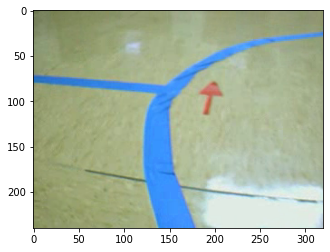

In [17]:
from matplotlib import pyplot as plt

#img_hsv[:, :, 1] = 255
plt.imshow(cv2.cvtColor(img_hsv, cv2.COLOR_HSV2RGB))

In [18]:
import numpy as np

data_marca = img_hsv[np.where((markImg[:, :, 0] == 255) & (markImg[:, :, 1] == 0) & (markImg[:, :, 2] == 0))]
data_fondo = img_hsv[np.where((markImg[:, :, 0] == 0) & (markImg[:, :, 1] == 255) & (markImg[:, :, 2] == 0))]
data_linea = img_hsv[np.where((markImg[:, :, 0] == 0) & (markImg[:, :, 1] == 0) & (markImg[:, :, 2] == 255))]

In [19]:
import pandas as pd
linea = pd.DataFrame(data_linea[:,0:2], columns=['h', 's'])
marca = pd.DataFrame(data_marca[:,0:2], columns=['h', 's'])
suelo = pd.DataFrame(data_fondo[:,0:2], columns=['h', 's'])

linea['clase'] = 0
marca['clase'] = 1
suelo['clase'] = 2

In [20]:
df = pd.concat([linea, marca, suelo], axis=0)

In [21]:
#df.drop(columns=["s"], inplace=True)

Text(0.5, 1.0, 'Espacio HS ')

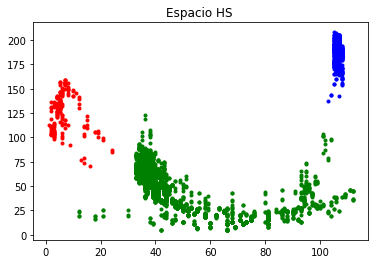

In [23]:
plt.figure()
plt.plot(df[df.clase==1].h,df[df.clase==1].s,'r.',label='marca')
plt.plot(df[df.clase==2].h,df[df.clase==2].s,'g.',label='fondo')
plt.plot(df[df.clase==0].h,df[df.clase==0].s,'b.',label='linea')
plt.title('Espacio HS ')

In [24]:
from imblearn.over_sampling import SMOTEN
sampler = SMOTEN(random_state=0)

df_smote, clase_smote = sampler.fit_resample(df.drop(columns=['clase']), df.clase)

In [25]:
df_smote['clase'] = clase_smote
df_smote.clase.value_counts()

0    6761
1    6761
2    6761
Name: clase, dtype: int64

Text(0.5, 1.0, 'Espacio HS sintético mediante oversampling ')

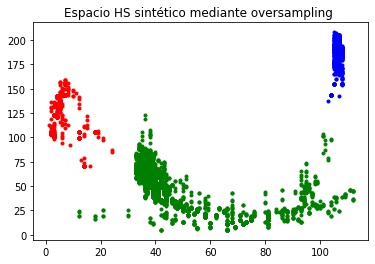

In [27]:
plt.figure()
plt.plot(df_smote[df_smote.clase==1].h,df_smote[df_smote.clase==1].s,'r.',label='marca')
plt.plot(df_smote[df_smote.clase==2].h,df_smote[df_smote.clase==2].s,'g.',label='fondo')
plt.plot(df_smote[df_smote.clase==0].h,df_smote[df_smote.clase==0].s,'b.',label='linea')
plt.title('Espacio HS sintético mediante oversampling ')

In [28]:
df_smote.to_csv("segmentation2D.csv", index=False)

In [2]:
import pandas as pd
df_smote = pd.read_csv("segmentation2D.csv")
df_smote.head()

,h,s,clase
0,108,166,0
1,108,166,0
2,107,175,0
3,107,175,0
4,108,160,0


In [3]:
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.model_selection import cross_validate

clf = QuadraticDiscriminantAnalysis()
cv_results = cross_validate(clf, df_smote.drop(columns=['clase']), df_smote.clase, cv=5)

In [5]:
import numpy as np
print("Cross Validation:")
print("score: ",np.mean(cv_results['test_score'])*100,", Std: ", np.std(cv_results['test_score']))

Cross Validation:
score:  98.46178883844078 , Std:  0.0027552793004873956


In [6]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(df_smote.drop(columns=['clase']), df_smote.clase, test_size=0.20, random_state=42, shuffle=True)

In [7]:
from sklearn.neighbors import KNeighborsClassifier
clf = QuadraticDiscriminantAnalysis()
clf.fit(X_train, y_train)
clf.score(X_test, y_test)

0.9857037219620409

In [8]:
import joblib

joblib.dump(clf, 'segmentation_model.jl')

['segmentation_model.jl']

In [47]:
preds = clf.predict(X_test)

Text(0.5, 1.0, 'Espacio HS sintético mediante oversampling ')

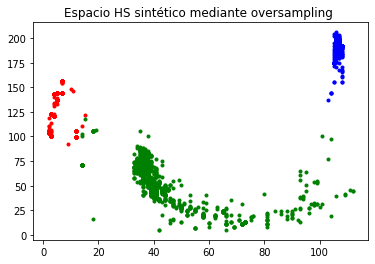

In [48]:
plt.figure()
plt.plot(X_test[preds==1].h,X_test[preds==1].s,'r.',label='marca')
plt.plot(X_test[preds==2].h,X_test[preds==2].s,'g.',label='fondo')
plt.plot(X_test[preds==0].h,X_test[preds==0].s,'b.',label='linea')
plt.title('Espacio HS sintético mediante oversampling ')

In [40]:
def etiquetar_imagen(clf, imagen):
    shape0 = imagen.shape[0]
    shape1 = imagen.shape[1]
    img = imagen.reshape(imagen.shape[0]*imagen.shape[1], 2)
    predictions = clf.predict(img)
    return predictions.reshape(shape0, shape1)

In [41]:
def pintar_prediccion(prediccion):
    paint = np.zeros((prediccion.shape[0], prediccion.shape[1], 3))
    paint[np.where(prediccion == 0)] = [255, 0, 0]
    paint[np.where(prediccion == 1)] = [0, 0, 255]
    paint[np.where(prediccion == 2)] = [0, 255, 0]
    # plt.imshow(paint)
    # plt.show()
    return paint

In [42]:
def procesarimagen(imagen, clf):
    img_hsv = cv2.cvtColor(imagen, cv2.COLOR_BGR2HSV)
    img2 = img_hsv[:,:,0:2]
    pred = etiquetar_imagen(clf, img2)
    return pintar_prediccion(pred)

In [43]:
import cv2
import datetime

def etiqueta_video(videopath, clf):
    init_time = datetime.datetime.now()
    ct = str(datetime.datetime.now())
    capture = cv2.VideoCapture(videopath)
    fps = capture.get(cv2.CAP_PROP_FPS)
    width = int(capture.get(cv2.CAP_PROP_FRAME_WIDTH))
    height =  int(capture.get(cv2.CAP_PROP_FRAME_HEIGHT))
    fourcc = cv2.VideoWriter_fourcc(*'mp4v')
    video = cv2.VideoWriter('video'+ct+'.avi', fourcc, fps, (width, height))
    while capture.isOpened():
        ret, frame = capture.read()
        if ret == False:
            break
        processed_img = procesarimagen(frame, clf)
        video.write(np.uint8(processed_img))

    cv2.destroyAllWindows()
    video.release()
    print("Tiempo de proceso = ", datetime.datetime.now()-init_time)

In [45]:
etiqueta_video("/home/dani/Escritorio/proyectos/Python/clase/robotica/Robotica/codigo_alumnos2021/segmentacion/video2017-3.avi",  clf)

/home/dani/.config/JetBrains/JetBrainsDS2021.3/projects/workspace/venv/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but QuadraticDiscriminantAnalysis was fitted with feature names
  warnings.warn(
/home/dani/.config/JetBrains/JetBrainsDS2021.3/projects/workspace/venv/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but QuadraticDiscriminantAnalysis was fitted with feature names
  warnings.warn(
/home/dani/.config/JetBrains/JetBrainsDS2021.3/projects/workspace/venv/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but QuadraticDiscriminantAnalysis was fitted with feature names
  warnings.warn(
/home/dani/.config/JetBrains/JetBrainsDS2021.3/projects/workspace/venv/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but QuadraticDiscriminantAnalysis was fitted with feature names
  warnings.wa

Tiempo de proceso =  0:02:06.178393


/home/dani/.config/JetBrains/JetBrainsDS2021.3/projects/workspace/venv/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but QuadraticDiscriminantAnalysis was fitted with feature names
  warnings.warn(
/home/dani/.config/JetBrains/JetBrainsDS2021.3/projects/workspace/venv/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but QuadraticDiscriminantAnalysis was fitted with feature names
  warnings.warn(
/home/dani/.config/JetBrains/JetBrainsDS2021.3/projects/workspace/venv/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but QuadraticDiscriminantAnalysis was fitted with feature names
  warnings.warn(
